# STEP 4: Modeling strategy and selection of Best Model

## Description of the methodology
> * **Finalisation of the class definition of the Target Variable (ALL_Impact) and company related feature**
* **Model selection performance indicators (e.g. Accuracy, confusion matrix and associated metrics: precision, recall and F1 score)**
* **Definition of the best trade-off for the number of components for the PCA dimension reduction process**
* **Split of dataset (train & test/validate samples)**
* **Description of the approach for minimizing overfitting: cross-validation with stratified k-folds**
* **Definition of the Baseline model: Most frequent class. As an alternative, we could explore Naive Bayes classifier or Logistic Regression (depending on the class definition of the Target Variable)**
* **Results of Baseline model selected**
* **Rationale of the 2 types of model classifier selected: SVM and Random Forest**

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.fftpack as sp

%matplotlib inline
import matplotlib.pyplot as plt

import re
from sklearn.preprocessing import Normalizer
import os
from sklearn import preprocessing
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import ComplementNB, MultinomialNB

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import scikitplot as skplt

# t_NSE dimensionality reduction
from sklearn.manifold import TSNE

import random
from sklearn import ensemble

from sklearn.model_selection import StratifiedShuffleSplit

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")


# Activate Seaborn style
sns.set()

## Load the file for analysis

In [2]:
# Importing the file and creating a dataframe
master_modeling = pd.read_csv(
    "master_modeling.csv",
    low_memory=False,
    skipinitialspace=True,
)  # , sep='\t'

In [3]:
# display all columns
pd.set_option("display.max_columns", None)

In [4]:
# remove the Unnamed column
master_modeling.drop("Unnamed: 0", axis=1, inplace=True)
master_modeling.shape

(194484, 351)

In [5]:
# Create a dataframe for the modeling phase (without text and not relevant features)
df_modeling = master_modeling.drop(["Title", "Post_ID", "Snippet"], axis=1)

In [6]:
df_modeling.shape

(194484, 348)

## Definition of # of classes for the Target Variable 'All_Impact'

> * We will split the variable in 3 classes using Scikit Learn preprocessing function KBinDiscretizer with the following parameters: number of bins 3, encode: ordinal and strategy: quantile
* Oridinal has been selected as we are trying to model a hierarchy between low and high tweet impact
* Quantile implies an even number of data points per class which would shape the model to learn about features for each class equally (avoiding unbalance classes)
* We may reconsider some of the value of the parameters depending on the modeling results

In [7]:
ai_bin = master_modeling[["ALL_Impact"]]

In [8]:
# Process binizer
est = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="quantile")
est.fit(ai_bin)
new_ai = est.transform(ai_bin)

In [9]:
# Call the edge of the different 3 bins
est.bin_edges_[0]

array([ 0., 30., 41., 80.])

In [10]:
new_ai_df = pd.DataFrame(new_ai)

In [11]:
new_ai_df.shape

(194484, 1)

In [12]:
df_modeling["All_impact bin"] = new_ai_df

In [13]:
df_modeling["All_impact bin"].value_counts()

2.0    69658
1.0    63049
0.0    61777
Name: All_impact bin, dtype: int64

In [14]:
# Remove the original All_Impact feature
df_modeling2 = df_modeling.drop(
    ["ALL_Impact", "TW_Hashtags", "ALL_Author", "TW_Account_Name"], axis=1
)

In [15]:
# Transform new All Impact feature type into int64
df_modeling2["All_impact bin"] = df_modeling2["All_impact bin"].astype(np.int64)

In [16]:
df_modeling2.shape

(194484, 345)

## Definition of the model performance metrics
> * As we are dealing with classifiers we will look at accuracy, f1 scores using Scikit Learn confusion report

## Definition of the best trade-off for the number of components for the PCA dimension reduction process
> * We will apply PCA to all features (except target variable) in order to evaluate the number of components which could explain 80% to 99% of the variance
* It will help to optimize computing resources while keeping a good level of information for the modeling process

### Create X and y arrays

In [17]:
# Create an array from df_modeling2 excluding the target variable All impact bin
X = df_modeling2.drop(["All_impact bin"], axis=1)
X = np.array(X)
X.shape

(194484, 344)

In [18]:
# Create y array for the target variable All impact bin
y = df_modeling2["All_impact bin"]
y = np.array(y)
y.shape

(194484,)

### Standardize features

In [19]:
# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_rescaled = scaler.fit_transform(X)

In [20]:
# Create PCA transformer
pcan = PCA(n_components=None)

# Apply PCA to the df_modeling2 dataframe
pcan.fit(X_rescaled)

# Proportion of variance explained
pveo = pcan.explained_variance_ratio_

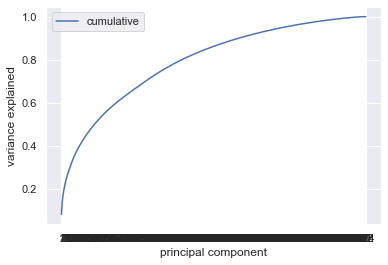

In [21]:
# Create plot
xcor = np.arange(1, len(pveo) + 1)  # 1,2,..,n_components
plt.xticks(xcor)

# Add cumulative sum
pveo_cumsum = np.cumsum(pveo)
plt.plot(
    xcor, pveo_cumsum, label="cumulative"  # 1.5,2.5,..,n_components  # Cumulative sum
)

# Add labels
plt.xlabel("principal component")
plt.ylabel("variance explained")
plt.legend()
plt.show()

In [22]:
# 80% of the variance explained
pveo80 = pveo_cumsum[pveo_cumsum <= 0.80]
cumvar_80 = np.count_nonzero(pveo80)

# 90% of the variance explained
pveo90 = pveo_cumsum[pveo_cumsum <= 0.90]
cumvar_90 = np.count_nonzero(pveo90)

# 95% of the variance explained
pveo95 = pveo_cumsum[pveo_cumsum <= 0.95]
cumvar_95 = np.count_nonzero(pveo95)

# 99% of the variance explained
pveo99 = pveo_cumsum[pveo_cumsum <= 0.99]
cumvar_99 = np.count_nonzero(pveo99)

print("Cum. Var.80%:", cumvar_80)
print("Cum. Var.90%:", cumvar_90)
print("Cum. Var.95%:", cumvar_95)
print("Cum. Var.99%:", cumvar_99)

Cum. Var.80%: 136
Cum. Var.90%: 200
Cum. Var.95%: 250
Cum. Var.99%: 312


### Conclusions about the number of components kept for the PCA process
> * We will tune PCA with 200 components

## Create a train, validation and test datasets (from the main Train set of data)
> * As we are going to optimize hyper-parameters of models with GridSearch, we need to differentiate train/test datasets in 2 groups: the one used for tuning hyper-parameters and the second for processing the best model selected out of the hyper-parameter optimization
* We will run different configuration of decision trees and SVM in order to select the Best Model (overall) that we will apply on the original Test dataset
* We could limit the risk of overfitting by using a cross-validation approach. However, we may run the risk of very demanding computing resources as we will combine hyper-parameter optimizatio (GridSearch) and large dataset (194484 rows x 344 variables).
* A compromised approach would be to use the standard train/test dataset split and leverage Cross-validation for the validation phase in the process for select the best model.

In [23]:
X.shape

(194484, 344)

In [24]:
# Convert the type of the input matrix to float
X = X.astype(np.float)

# Create train set
X_tr_main, X_test, y_tr_main, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Create validation and test sets
X_tr_2nd, X_valid, y_tr_2nd, y_valid = train_test_split(
    X_tr_main, y_tr_main, test_size=1500, train_size=5000, random_state=0
)

print("Train:", X_tr_main.shape, y_tr_main.shape)
print("Test:", X_test.shape, y_test.shape)
print("Train2:", X_tr_2nd.shape, y_tr_2nd.shape)
print("Valid:", X_valid.shape, y_valid.shape)

Train: (155587, 344) (155587,)
Test: (38897, 344) (38897,)
Train2: (5000, 344) (5000,)
Valid: (1500, 344) (1500,)


In [25]:
pd.value_counts(y_valid, normalize=True)

2    0.369333
1    0.322000
0    0.308667
dtype: float64

## Definition of the Baseline model
> * We will consider 2 Baseline models: Most Frequent class (to evaluate an approached based on the simple distribution of data points) and Logistic Regression as a simple model
* It will provide us with a range of a basic estimate (most frequent class) and a more realistic model for which the comparison with optimized classifiers will be more meaningful and relevant
* The gap of accuracy results between the 2 baseline approaches would indicate the quality of data and pre-processing step

### Most Frequent class
> * class 1 (87572) / total number of tweets (194484) = **45%**

### Logistic Regression
> * We will apply Logist Regression which a robust algorithm and no highly demanding in terms of computational resources

#### Create a Logistic Regression pipeline

In [26]:
# Create Logistic Regression pipeline
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),  # with standardization
        ("PCA", PCA(n_components=200)),  # 200 components to explain 95% of the variance
        (
            "sgd_logreg",
            SGDClassifier(
                loss="log", max_iter=1000, tol=1e-3, random_state=0, n_jobs=-1
            ),
        ),
    ]
)

#### Run the Logistic Regression model on sub-train data set (10 000 tweets) and test accuracy on the validation data set (2 500 tweets)

In [27]:
# Fit the model
pipe.fit(X_tr_2nd, y_tr_2nd)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('sgd_logreg',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='log',
                               max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                               penalty='l2', power_t=0.5, random_state=0,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

#### Print Mean accuracy

In [28]:
accuracy = pipe.score(X_valid, y_valid)
print("Mean accuracy:", accuracy)

Mean accuracy: 0.7946666666666666


#### Print Classification report and plot the Confusion matrix

In [29]:
# Make prediction on X-valid dataset
y_pred_lr = pipe.predict(X_valid)

In [30]:
# Confusions report
target_names = ["class 0", "class 1", "class 2"]
print(classification_report(y_valid, y_pred_lr, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.82      0.92      0.87       463
     class 1       0.75      0.58      0.66       483
     class 2       0.79      0.88      0.83       554

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500



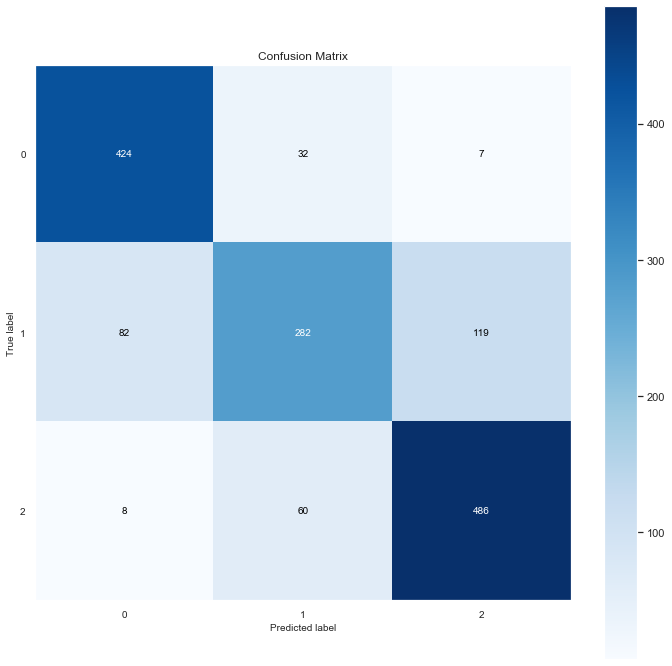

In [31]:
# Confusion matrix plot
cm_logreg = skplt.metrics.plot_confusion_matrix(y_valid, y_pred_lr, figsize=(12, 12))

### Save the results for visualization at a later stage

In [33]:
Logreg_acc = 0.8064
c1_logreg_f1 = 0.88
c2_logreg_f1 = 0.68
c3_logreg_f1 = 0.83

%store Logreg_acc
%store c1_logreg_f1
%store c2_logreg_f1
%store c3_logreg_f1

Stored 'Logreg_acc' (float)
Stored 'c1_logreg_f1' (float)
Stored 'c2_logreg_f1' (float)
Stored 'c3_logreg_f1' (float)


### Conclusions about Logistic Regression results
> * Overall the **accuracy is good (0.8064)**. The accuracy % vs the Most Frequent Class (45%) indicates that the model can benefit from the quality of data and pre-processing step
* Whilst the overall **f1 score is good for the class 0 and 2 (respectively 0.88 and 0.83), class 1 f1 score is lower (0.68)** vs the 2 other classes
* The class 1 presents a "bad prediction" almost evenly distributed between the 2 other classes (not the case for the class 1 and 2)
* We can highlight as well that class 1 is the one with the lowest bin width (30 to 41) vs the 2 other classes
* At this stage, we cannot identify the main reasons for such performance without digging into the data. We will keep a specific attention to this fact when looking at the resuts of the other models

## Rationale of the 2 types of model classifier selected: SVM and Random Forest
> * The machine learning objective is to select 2 classes of classifiers which are distinctive enough in terms of fundamental approach and ability to process better (or not) certain types of features and structure of dataset (e.g. numerical vs categorical, high number of features, linear relationship vs non-linear between features...)
* **Random Forest** (RF) is selected as the first class as it is a robust technique and efficient for dealing with a combination of numerical and categorical features. This algorithm performs well with high dimensional spaces and large number of training data points. Its good level of interpretability makes it as well a good candidate for this project. However, it tends to overfit that we will try to mitigate via hyper-parameter tuning and Cross-validation. An alternaive decision tree classifier (i.e. AdaBoost) would be consider depending on the performance of Random Forest
* **Support Vector Machine** (SVM) is selected as the second class. It is a good complement of RF as it supports well high-dimensional space (e.g. used for text classification). It is recommended for non-linear problem while it can be tuned with different Kernels. However, on the down side, it is harder to interpret vs RF (or Logistic Regression) and would demand a higher level of computing resources, especially if the training set is large. In order to take benefit of the different kernels, we will tune a linear and non-linear approaches.